In [3]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from modelingtools import delay_time_series, plot_activity_on_brain
from modelingtools import (plot_cv_indices, cross_validate_alpha)

from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn.learning_curve import learning_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, r2_score

import os
import seaborn as sns
import matplotlib.collections as clt
import ptitprince as pt

import sys
np.set_printoptions(threshold=sys.maxsize)

from sklearn import cross_validation as cv
import csv

In [5]:
outdir = '/Volumes/LBCN8T_2/Stanford/data/encoding/raw/VTCLoc/'
## Load Stim features
data = pd.read_csv(outdir + '132' + '_stim_features.csv')
## Load Brain features
#data.loc[data.loc[:,'HFB']>30, 'HFB'] = 0
y_tmp = pd.read_csv(outdir + '132' + '_brain_features.csv', header=None)
y = y_tmp.to_numpy()

In [8]:
data

,task,trial,time,block,task_general_cond_name,task_type,StimulusOnsetTime,allonsets,RT_lock,bodies,buildings_scenes,faces,falsefonts,logos,numbers,objects,scrambled_images,shapes,words
0,1,1,0.000,1,1,1,7.874616e+06,122.088,0.0,1,0,0,0,0,0,0,0,0,0
1,1,1,0.002,1,1,1,7.874616e+06,122.088,0.0,1,0,0,0,0,0,0,0,0,0
2,1,1,0.004,1,1,1,7.874616e+06,122.088,0.0,1,0,0,0,0,0,0,0,0,0
3,1,1,0.006,1,1,1,7.874616e+06,122.088,0.0,1,0,0,0,0,0,0,0,0,0
4,1,1,0.008,1,1,1,7.874616e+06,122.088,0.0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357835,1,840,0.842,2,4,1,7.876040e+06,667.410,0.0,0,0,0,1,0,0,0,0,0,0
357836,1,840,0.844,2,4,1,7.876040e+06,667.410,0.0,0,0,0,1,0,0,0,0,0,0
357837,1,840,0.846,2,4,1,7.876040e+06,667.410,0.0,0,0,0,1,0,0,0,0,0,0
357838,1,840,0.848,2,4,1,7.876040e+06,667.410,0.0,0,0,0,1,0,0,0,0,0,0


In [9]:
# Define trials 
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data)
trials = int(r/times)
trials_rs = np.matlib.repmat(np.arange(1,trials+1),times,1).T
trials_rs = trials_rs.reshape(-1,1)
data['trials'] = trials_rs

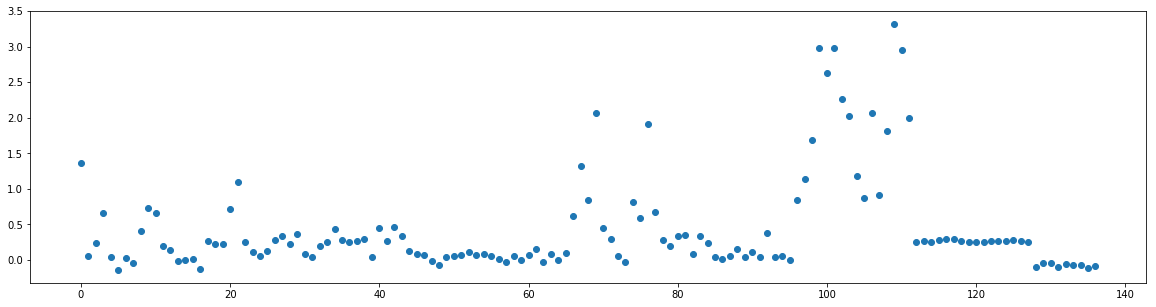

In [10]:
## Average activation electrodes
fig, ax = plt.subplots(1,1,figsize=(20, 5))
plt.scatter(np.arange(0,y.shape[1]),np.average(y, axis=0))

In [11]:
# Get a face selective electrode
y = y[:,77]

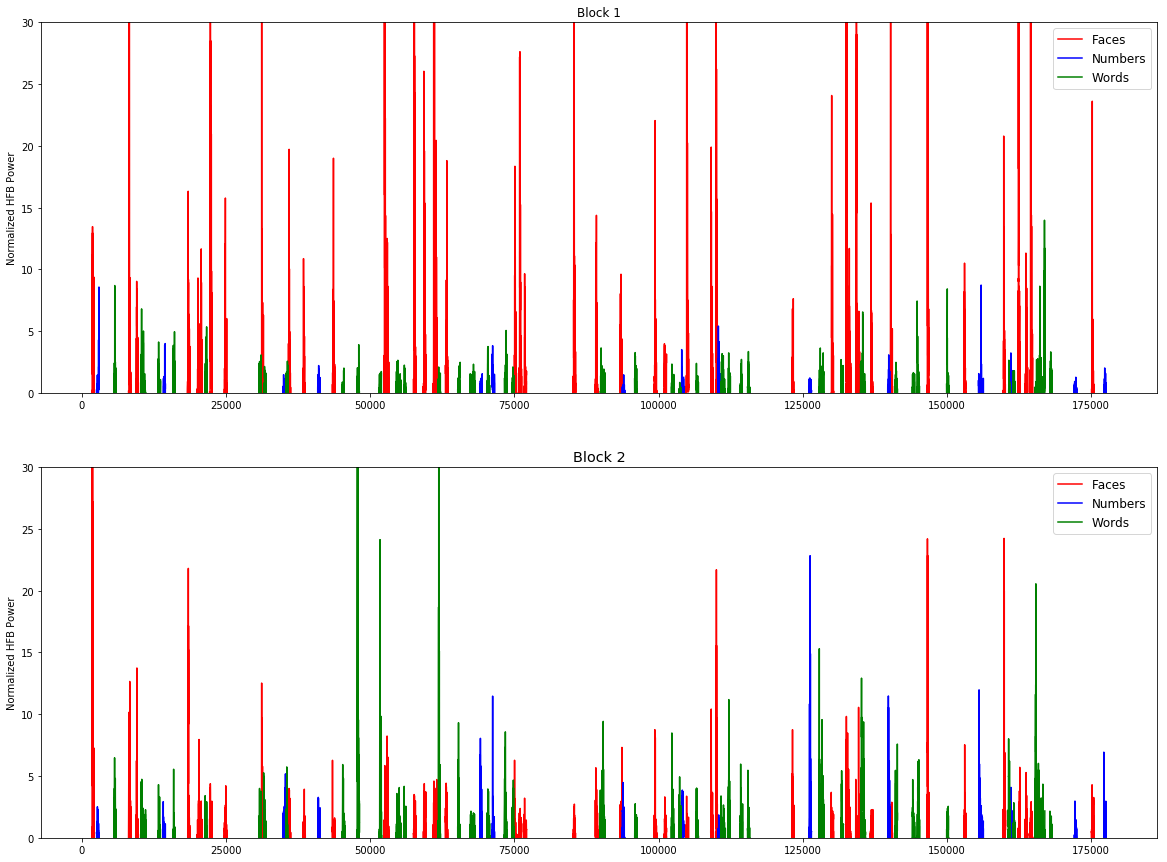

In [12]:
# Plot some marked trials
n_blocks = np.int(np.max(data.loc[:,'block']))
fig, ax = plt.subplots(n_blocks,1,figsize=(20, 15))

# Filter trials
face_trials = y.copy()
face_trials[data.loc[:,'faces']!=1] = np.nan
number_trials = y.copy()
number_trials[data.loc[:,'numbers']!=1] = np.nan
words_trials = y.copy()
words_trials[data.loc[:,'words']!=1] = np.nan


for i in range(n_blocks):
    #ax[i].plot(samples[data[:,4]==i+1], data[data[:,4]==i+1,3])
    ax[i].plot(face_trials[data.loc[:,'block']==i+1], 'r', label="Faces")
    ax[i].plot(number_trials[data.loc[:,'block']==i+1], 'b', label="Numbers")
    ax[i].plot(words_trials[data.loc[:,'block']==i+1], 'g', label="Words")
    ax[i].set_ylim([0,30])
    ax[i].set_title('Block ' + str(i+1))
    plt.rcParams.update({'font.size': 12}) 
    ax[i].set_ylabel('Normalized HFB Power')
    ax[i].legend()

In [14]:
# List some stimuli features and add delays

#features_list = list(['faces', 'numbers', 'words'])
features_list = list(['faces', 'numbers', 'words', 'bodies', 'buildings_scenes', 'falsefonts', 'logos', 'objects', 'scrambled_images', 'shapes'])

# Add delayed features
fs = 500
time_window = 0.02;
#n_delays = 100
#delays = np.linspace(1, 2, 100)
start = 0; stop = 0.8; step = time_window
delays = np.arange(start, stop+step, step)
n_delays = int(len(delays))
print(n_delays)

41


In [25]:
# Prepare the delayed features
X_all = np.zeros((y.shape[0], n_delays), int)

for fi in range(0,len(features_list)):
    print(fi)
    print(features_list[fi])
    features = np.array(data.loc[:,features_list[fi]]) # result
    times = np.shape(np.unique(data.loc[:,'time']))
    times = int(times[0])
    r,c = np.shape(data)
    trials = int(r/times)

    # Reshape features
    features_reshape = np.reshape(features, (trials, times))
    features_reshape = np.expand_dims(features_reshape, axis=1)

    X_delayed = np.zeros((trials,1,n_delays,times))
    for i in range(trials):
        for ii in range(n_delays):
            window = [int(np.round(delays[ii]*fs)),int(np.round((delays[ii]+time_window)*fs))]
            X_delayed[i,0,ii,window[0]:window[1]] = int(np.unique(features_reshape[i]))
    
    # Concatenate back the delayed features
    X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
    X = np.hstack(X_env).T
    print(X.shape)
    #print(X2.shape)
    X_all = np.append(X_all,X, axis=1)
    print(X_all.shape)

0
faces
(357840, 41)
(357840, 82)
1
numbers
(357840, 41)
(357840, 123)
2
words
(357840, 41)
(357840, 164)
3
bodies
(357840, 41)
(357840, 205)
4
buildings_scenes
(357840, 41)
(357840, 246)
5
falsefonts
(357840, 41)
(357840, 287)
6
logos
(357840, 41)
(357840, 328)
7
objects
(357840, 41)
(357840, 369)
8
scrambled_images
(357840, 41)
(357840, 410)
9
shapes
(357840, 41)
(357840, 451)


In [17]:
X_all.shape

(357840, 451)

In [48]:
X_all = X_all[:,n_delays-1:-1]
print(X_all.shape)

(357840, 410)


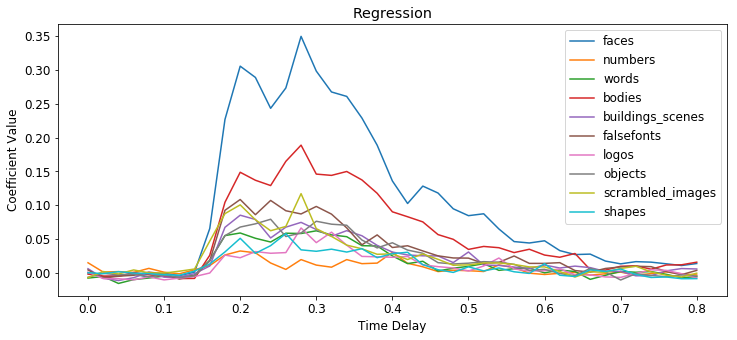

In [51]:
coefs = est.steps[-1][-1].coef_
coefs_rs = np.reshape(coefs, (len(features_list), n_delays))
# Plot results
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(np.abs(delays), coefs_rs.T)

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
_ = ax.legend(['faces', 'numbers', 'words', 'bodies', 'buildings_scenes', 'falsefonts', 'logos', 'objects', 'scrambled_images', 'shapes'])

In [73]:
X_all.shape

(357840, 410)

In [52]:
predictions = est.predict(X_all)

0.11752934297285389


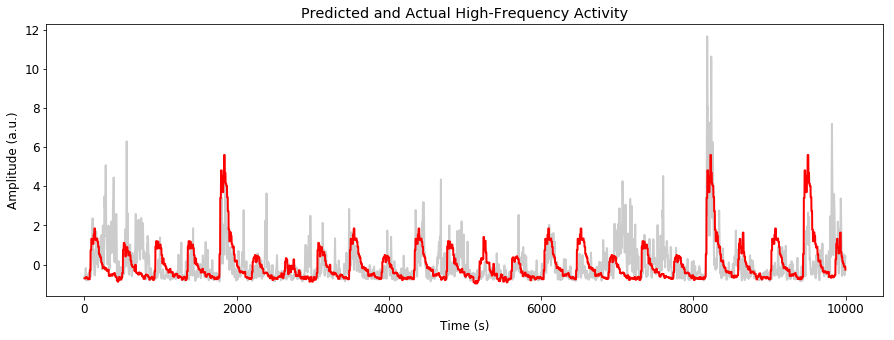

In [57]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title('Predicted and Actual High-Frequency Activity')
ax.set_ylabel('Amplitude (a.u.)')
ax.set_xlabel('Time (s)')

ax.plot(scale(y[1:10000]), color='k', alpha=.2, lw=2)
ax.plot(scale(predictions[1:10000]), color='r', lw=2)
ax.axis('tight')

# Finally, plot the coefficient of determination (R2)
print(r2_score(y, predictions))

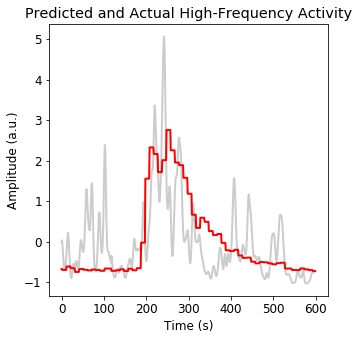

In [60]:
## Zoom on a given trial
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title('Predicted and Actual High-Frequency Activity')
ax.set_ylabel('Amplitude (a.u.)')
ax.set_xlabel('Time (s)')

ax.plot(scale(y[18200:18800]), color='k', alpha=.2, lw=2)
ax.plot(scale(predictions[18200:18800]), color='r', lw=2)

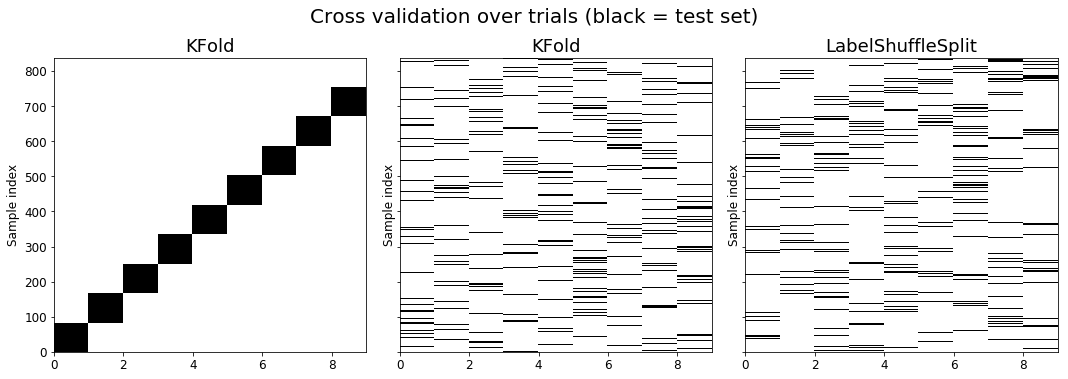

In [61]:
## Cross validation
trials = np.arange(1,trials)
# We'll use the KFold iterator, shuffling trial numbers first
n_cv_iterations = 10
cross_val_iterator = cv.KFold(len(trials), n_folds=5, shuffle=True)
#model = Ridge(alpha=1e5)
model = make_pipeline(StandardScaler(), Ridge())

# Iterating across trials (labels)
trials = np.arange(len(trials))
cv_iterators = [cv.KFold(len(trials), n_folds=n_cv_iterations),
                cv.KFold(len(trials), n_folds=n_cv_iterations, shuffle=True),
                cv.LabelShuffleSplit(trials, n_iter=n_cv_iterations,
                                     test_size=.1)]

fig, axs = plt.subplots(1, len(cv_iterators), figsize=(15, 5),
                        sharey=True, sharex=True)
for ax, icv in zip(axs, cv_iterators):
    ax = plot_cv_indices(icv, ax)
    ax.set_title(type(icv).__name__, fontsize=18)
fig.suptitle('Cross validation over trials (black = test set)',
             fontsize=20, y=1.05)
plt.tight_layout()

0.06871486420024742
0.12135857273395279
0.13295787895585154
0.057737296947326655
0.005045214125423025


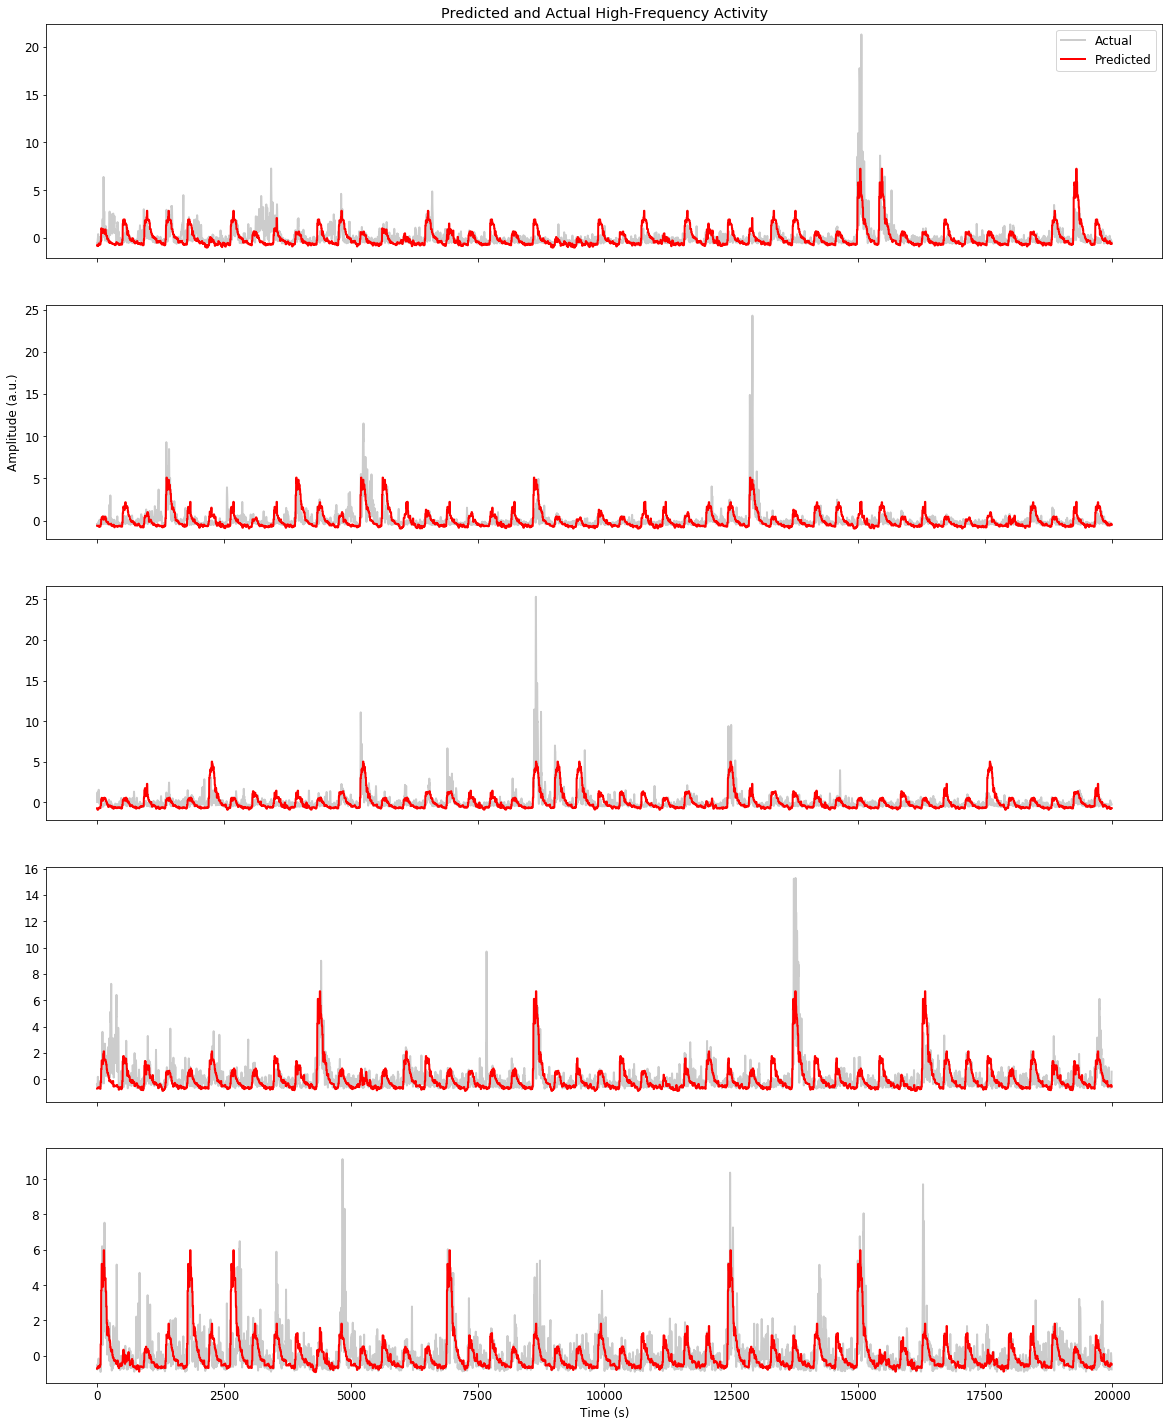

In [76]:
fig, axs = plt.subplots(len(cross_val_iterator), 1,
                        figsize=(20, 5*len(cross_val_iterator)),
                        sharex=True)
axs[0].set_title('Predicted and Actual High-Frequency Activity')
axs[1].set_ylabel('Amplitude (a.u.)')
axs[-1].set_xlabel('Time (s)')

# Iterate through cross-validation splits
for ax, (tr, tt) in zip(axs, cross_val_iterator):
    # Pull the training / testing data for the ecog data
    y_tr = y[data['trials'].isin(tr)]
    y_tt = y[data['trials'].isin(tt)]

    # Pull the training / testing data for the stim features
    X_tr = X_all[data['trials'].isin(tr)]
    X_tt = X_all[data['trials'].isin(tt)]
        
    # Fit the model, and use it to predict on new data
    model = make_pipeline(StandardScaler(), Ridge())
    model.fit(X_tr, y_tr)
    predictions = model.predict(X_tt)
    
    # Plot the predicted and actual values.
    # We'll subtract the mean from each so it's easier to visualize
    ax.plot(scale(y_tt[1:20000]), color='k', alpha=.2, lw=2)
    ax.plot(scale(predictions[1:20000]), color='r', lw=2)
    ax.axis('tight')
    
    # Finally, plot the coefficient of determination (R2)
    print(r2_score(y_tt, predictions))

_ = axs[0].legend(['Actual', 'Predicted'])

In [77]:

y.shape[0]

357840

In [78]:
len(features_list)

10

In [79]:
def select_features(task):
    features_list = {'MMR': {'math', 'memory'},
                     'Memoria': {'math', 'memory'},
                     'VTCLoc': {'faces','numbers', 'words'}}
    features = list(features_list[task])
    return features

In [80]:
features = select_features('VTCLoc')

In [82]:
len(features)

3